# Devyan

Lets build an AI-powered software development assistant that orchestrates a team of agents to solve programming tasks.

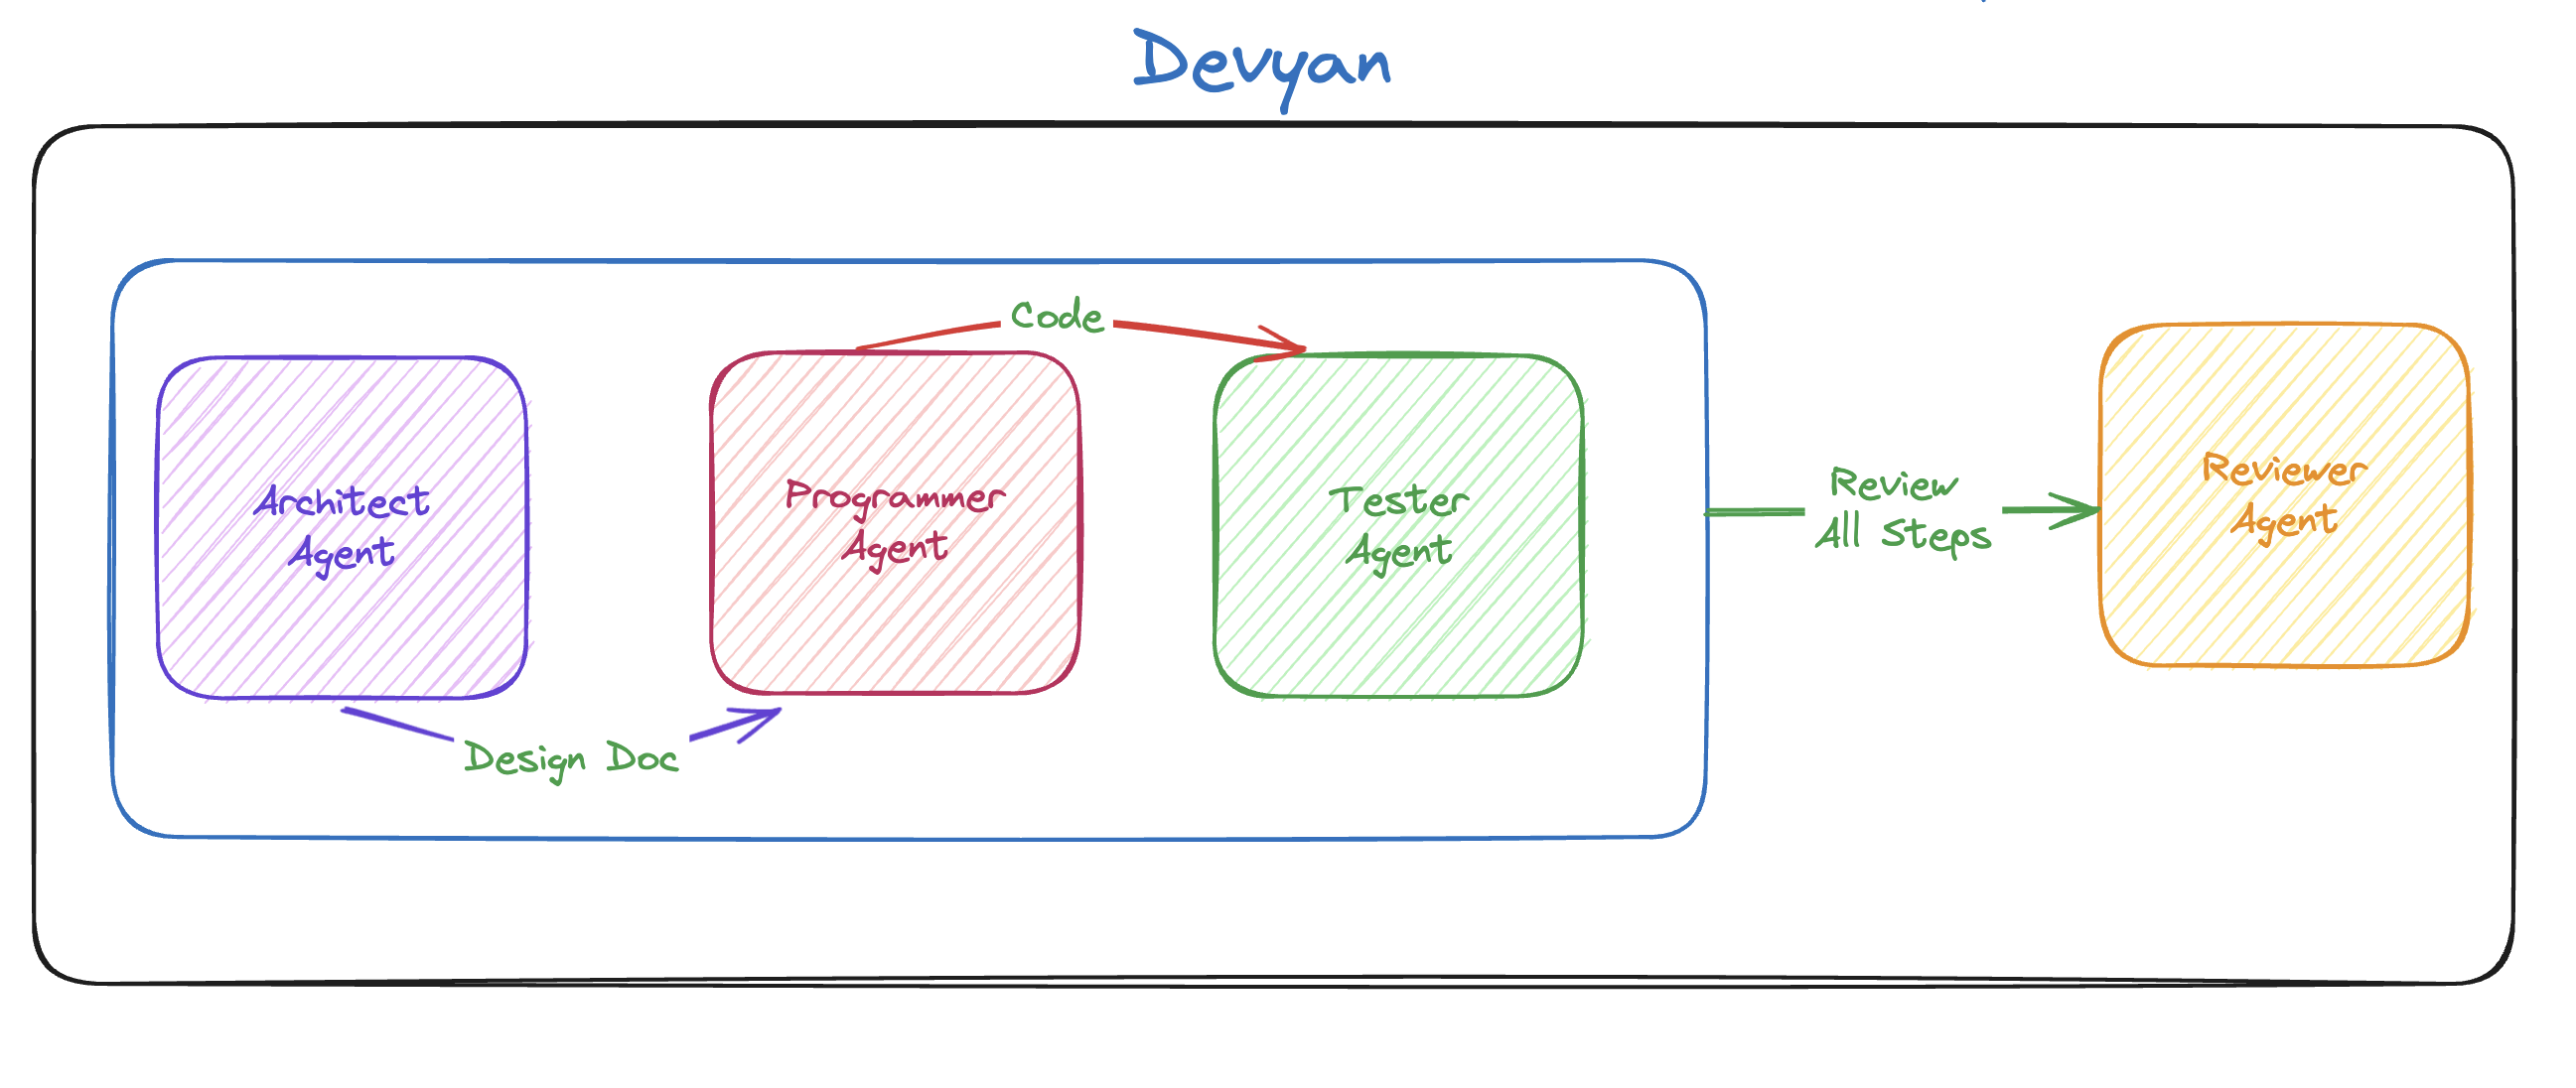

## Features

- **Architect Agent**: Designs the architecture of the solution based on the user input.
- **Programmer Agent**: Implements the solution as per the architecture design.
- **Tester Agent**: Tests the implemented solution to ensure it meets the requirements and is free of bugs.
- **Reviewer Agent**: Reviews the architecture, implementation, and test results to provide a comprehensive analysis.

In [ ]:
# Import necessary classes from the crewai library
from crewai import Agent, Task, Crew

from textwrap import dedent


print("Libraries imported successfully.")

In [ ]:
class CustomAgents:
    def __init__(self):
        self.OpenAIGPT4 = ChatOpenAI(model_name="gpt-4o", temperature=0.7)
        # self.Ollama = ChatOpenAI(model_name="devainllama3", base_url = "http://localhost:11434/v1")

    def architect_agent(self, tools):
        return Agent(
            role="Software Architect",
            backstory=dedent(f"""\
            With years of experience in system design,
            you excel at breaking down complex problems into manageable solutions,
            providing a solid foundation for implementation."""),
            goal=dedent(f"""\
            Provide a high-level solution overview for a given problem"""),
            tools=tools,
            allow_delegation=False,
            verbose=True,
            llm=self.OpenAIGPT4,
        )

    def programmer_agent(self, tools):
        return Agent(
            role="Software Programmer",
            backstory=dedent(f"""\
            You havea keen eye for detail and a knack for translating high-level design solutions into robust,
            efficient code."""),
            goal=dedent(f"""Implement the solution provided by the architect"""),
            tools=tools,
            allow_delegation=False,
            verbose=True,
            llm=self.OpenAIGPT4,
        )

    def tester_agent(self, tools):
        return Agent(
            role="Software Tester",
            backstory=dedent(f"""\
            Your passion for quality ensures that every piece of code meets the highest
            standards through rigorous testing."""),
            goal = dedent("""\
            Write and run test cases for the code implemented by the programmer"""),
            tools=tools,
            allow_delegation=False,
            verbose=True,
            llm=self.OpenAIGPT4,
        )

    def reviewer_agent(self, tools):
        return Agent(
            role="Software Reviewer",
            backstory=dedent("""\
            With a critical eye, you review each step of the development process, ensuring quality and consistency."""),
            goal=dedent("""\
            Review the work of each agent at each step"""),
            tools=tools,
            allow_delegation=False,
            verbose=True,
            llm=self.OpenAIGPT4,
        )

In [ ]:
class CustomTasks:
    def __tip_section(self):
        return "If you do your BEST WORK, I'll give you a $10,000 commission!"

    def architecture_task(self, agent, tools, user_input):
        return Task(
            description=dedent(
                f"""
            Provide a high-level solution architecture for the given problem: {user_input}.
            Your final answer must include a clear overview and major components involved.
            {self.__tip_section()}
            You have access to tools which can search the internet, read files, write files and create directories
            """
            ),
            expected_output='A document outlining the high-level architecture.',
            tools=tools,
            agent=agent,
        )

    def implementation_task(self, agent, tools, context):
        return Task(
            description=dedent(
                f"""
            Implement the solution as per the architect's overview.
            Your final answer must include the code implementing the solution.
            {self.__tip_section()}
            You have access to tools which can read files, write files and create directories
            """
            ),
            expected_output='Python code (py files) implementing the solution.',
            tools=tools,
            agent=agent,
            context=context
        )

    def testing_task(self, agent, tools, context):
        return Task(
            description=dedent(
                f"""
            Write and run test cases for the implemented code.
            Your final answer must include test scripts and test results.
            {self.__tip_section()}
            You have access to tools which can read files, write files and create directories
            """
            ),
            expected_output='Test scripts and test document for the implemented code.',
            tools=tools,
            agent=agent,
            context=context
        )

    def reviewing_task(self, agent, tools, context):
        return Task(
            description=dedent(
                f"""
            Review the work done by each agent at each step.
            Your final answer must include feedback and necessary revisions.
            You should also know how to run the application which can be useful to the users.
            {self.__tip_section()}
            You have access to tools which can read files, write files and create directories
            """
            ),
            expected_output='Feedback and revisions for each step of the process. Also a final document which has steps to run the code given which can serve as a documentation for users',
            tools=tools,
            agent=agent,
            context=context
        )

In [ ]:
search_tool = DuckDuckGoSearchRun()
file_read_tool = FileReadTool()
file_write_tool = FileWriteTool.file_write_tool
dir_write_tool = DirWriteTool.dir_write_tool

# Tools
architect_tools = [search_tool, file_read_tool, file_write_tool, dir_write_tool]
programmer_tools = [file_read_tool, file_write_tool, dir_write_tool]
tester_tools = [file_read_tool, file_write_tool, dir_write_tool]
reviewer_tools = [file_read_tool, file_write_tool, dir_write_tool]

os.environ["OPENAI_API_KEY"] = config("OPENAI_API_KEY")


class CustomCrew:
    def __init__(self, user_input):
        self.user_input = user_input
    def run(self):
        agents = CustomAgents()
        tasks = CustomTasks()

        # Agents
        architect_agent = agents.architect_agent(architect_tools)
        programmer_agent = agents.programmer_agent(programmer_tools)
        tester_agent = agents.tester_agent(tester_tools)
        reviewer_agent = agents.reviewer_agent(reviewer_tools)

        # Tasks
        architecture_task = tasks.architecture_task(architect_agent, architect_tools, self.user_input)
        implementation_task = tasks.implementation_task(programmer_agent, programmer_tools, [architecture_task])
        testing_task = tasks.testing_task(tester_agent, tester_tools, [implementation_task])
        reviewing_task = tasks.reviewing_task(reviewer_agent, reviewer_tools, [architecture_task, implementation_task, testing_task])

        crew = Crew(
            agents=[architect_agent, programmer_agent, tester_agent, reviewer_agent],
            tasks=[architecture_task, implementation_task, testing_task, reviewing_task],
            verbose=True,
        )

        result = crew.kickoff()
        return result



if __name__ == "__main__":
    print("\n####### Welcome to Devyan #######")
    print("---------------------------------")
    user_input = input("What problem do you want me to solve?\n")
    crew = CustomCrew(user_input)
    result = crew.run()

    print("\n\n########################")
    print("## Here is you crew run result:")
    print("########################\n")
    print(result)